In [3]:
%matplotlib inline

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [49]:
class Vertex:
    def __init__(self, name, center, radius):
        self.name = name
        self.center = center
        self.radius = radius
        self.x = cp.Variable(2, name=f"{name}_x")
        self.z = cp.Variable(boolean=True, name=f"{name}_z")
        self.constraints = []

class Edge:
    def __init__(self, tail, head):
        self.tail = tail
        self.head = head
        self.z = cp.Variable(boolean=True, name=f"z_{tail.name}_to_{head.name}")
        self.dist = cp.Variable(nonneg=True, name=f"d_{tail.name}_to_{head.name}")
        self.constraints = []

class GraphOfConvexSets:
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, name, center, radius):
        v = Vertex(name, center, radius)
        self.vertices.append(v)
        return v

    def get_vertex_by_name(self, name):
        for v in self.vertices:
            if v.name == name:
                return v
        raise ValueError(f"Vertex with name {name} not found.")

    def add_edge(self, tail, head):
        e = Edge(tail, head)
        self.edges.append(e)
        return e


def create_3x3_graph():
    gcs = GraphOfConvexSets()
    n = 3
    radius = 0.3

    # Create 9 vertices
    for i in range(n):
        for j in range(n):
            name = f"({i},{j})"
            center = np.array([i, j])
            gcs.add_vertex(name, center, radius)

    # Define some directed edges
    edges = [
        ("(0,0)", "(1,0)"),
        ("(1,0)", "(2,0)"),
        ("(2,0)", "(2,1)"),
        ("(0,1)", "(0,0)"),
        ("(0,1)", "(0,2)"),
        ("(1,1)", "(1,0)"),
        ("(1,1)", "(0,1)"),
        ("(1,1)", "(1,2)"),
        ("(2,1)", "(1,1)"),
        ("(2,1)", "(2,2)"),
        ("(1,2)", "(0,2)"),
        ("(1,2)", "(2,2)"),
    ]
    for tail_name, head_name in edges:
        tail_v = gcs.get_vertex_by_name(tail_name)
        head_v = gcs.get_vertex_by_name(head_name)
        gcs.add_edge(tail_v, head_v)

    return gcs

def build_mi_formulation(gcs, start_name="(0,0)", goal_name="(2,2)"):
    constraints = []
    cost_terms = []
    M_vertex = 100.0
    M_edge = 100.0

    # Vertex constraints
    for v in gcs.vertices:
        dist_to_center = cp.norm(v.x - v.center, 2)
        constraints.append(dist_to_center <= v.radius + M_vertex*(1 - v.z))

    # Edge constraints + cost
    for e in gcs.edges:
        i, j = e.tail, e.head
        constraints.append(e.dist >= cp.norm(j.x - i.x, 2) - M_edge*(1 - e.z))
        constraints.append(e.dist <= M_edge * e.z)
        cost_terms.append(e.dist)

        # z_{ij} <= z_i, z_{ij} <= z_j, z_{ij} >= z_i + z_j -1
        constraints += [
            e.z <= i.z,
            e.z <= j.z,
            e.z >= i.z + j.z - 1
        ]

    # Flow constraints
    def in_flow(v):
        return cp.sum([e.z for e in gcs.edges if e.head == v])
    def out_flow(v):
        return cp.sum([e.z for e in gcs.edges if e.tail == v])

    start_v = gcs.get_vertex_by_name(start_name)
    goal_v = gcs.get_vertex_by_name(goal_name)

    for v in gcs.vertices:
        if v == start_v:
            constraints.append(out_flow(v) - in_flow(v) == 1)
        elif v == goal_v:
            constraints.append(in_flow(v) - out_flow(v) == 1)
        else:
            constraints.append(in_flow(v) - out_flow(v) == 0)

    # Objective
    objective = cp.Minimize(cp.sum(cost_terms))
    return constraints, objective

def solve_gcs(gcs):
    constraints, objective = build_mi_formulation(gcs)
    problem = cp.Problem(objective, constraints)
    # Must specify a MISOCP solver
    result = problem.solve(solver=cp.MOSEK, verbose=True)
    return result


def plot_gcs_topology_and_solution(gcs):

    fig, ax = plt.subplots(figsize=(6, 6))

    # --- First, draw all vertices + their circles + label at center
    for v in gcs.vertices:
        # Draw disk
        circle = plt.Circle(
            v.center, v.radius,
            facecolor='mintcream', edgecolor='black', linewidth=1.5, zorder=1
        )
        ax.add_patch(circle)

        # Mark the center name
        ax.text(
            v.center[0], v.center[1],
            v.name, ha='center', va='center', fontsize=9,
            color='black', zorder=2
        )

    # --- Second, draw all edges from center to center (light color)
    for e in gcs.edges:
        tail_center = e.tail.center
        head_center = e.head.center
        ax.annotate("",
                    xy=(head_center[0], head_center[1]),
                    xytext=(tail_center[0], tail_center[1]),
                    arrowprops=dict(arrowstyle="->", color="gray", lw=1),
                    zorder=1)

    # --- Third, highlight the chosen solution if z=1 for each vertex
    for v in gcs.vertices:
        # If v is used
        if v.z.value is not None and v.z.value > 0.5:
            # Plot the actual chosen point in red
            x_val = v.x.value
            ax.plot(x_val[0], x_val[1], 'ro', zorder=3)
            ax.text(x_val[0], x_val[1]+0.1, v.name + " (used)",
                    ha='center', va='bottom', fontsize=9, color='red')

    # --- Fourth, highlight the chosen edges if e.z=1
    for e in gcs.edges:
        if e.z.value is not None and e.z.value > 0.5:
            tail_val = e.tail.x.value
            head_val = e.head.x.value
            ax.annotate("",
                        xy=(head_val[0], head_val[1]),
                        xytext=(tail_val[0], tail_val[1]),
                        arrowprops=dict(arrowstyle="->", color="blue", lw=2),
                        zorder=3)

    ax.set_aspect('equal')
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 12:26:13 AM: Your problem has 51 variables, 78 constraints, and 0 parameters.
(CVXPY) Apr 17 12:26:13 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 12:26:13 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 12:26:13 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 12:26:13 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 12:26:13 AM: Compiling problem (target solver=MOSEK).
(C

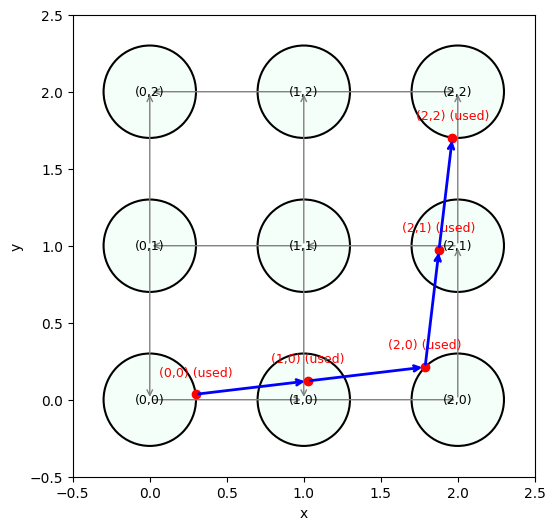

In [50]:
gcs = create_3x3_graph()

result = solve_gcs(gcs)
print("Optimal objective value:", result)

for v in gcs.vertices:
    if v.z.value is not None and v.z.value > 0.5:
        print(f"Vertex {v.name} used, x={v.x.value}")
    else:
        print(f"Vertex {v.name} not used")

for e in gcs.edges:
    if e.z.value is not None and e.z.value > 0.5:
        print(f"Edge {e.tail.name} -> {e.head.name} used, dist={e.dist.value:.3f}")

plot_gcs_topology_and_solution(gcs)

In [23]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

###############################################################################
# Vertex, Edge, and Graph classes
###############################################################################

class Vertex:
    def __init__(self, name, center, radius):
        self.name = name
        self.center = center
        self.radius = radius
        
        # Instead of boolean=True, we'll define z as a continuous var in [0,1].
        self.z = cp.Variable(name=f"{name}_z")  # relaxed to [0,1]
        self.x = cp.Variable(2, name=f"{name}_x")

        # We'll add constraints [0 <= z <= 1] in the build_relaxation() step
        self.constraints = []

class Edge:
    def __init__(self, tail, head):
        self.tail = tail
        self.head = head
        # Relax the edge usage variable to [0,1]
        self.z = cp.Variable(name=f"z_{tail.name}_to_{head.name}")  
        self.dist = cp.Variable(nonneg=True, name=f"d_{tail.name}_to_{head.name}")

        self.constraints = []

class GraphOfConvexSets:
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, name, center, radius):
        v = Vertex(name, center, radius)
        self.vertices.append(v)
        return v

    def get_vertex_by_name(self, name):
        for v in self.vertices:
            if v.name == name:
                return v
        raise ValueError(f"Vertex with name {name} not found.")

    def add_edge(self, tail, head):
        e = Edge(tail, head)
        self.edges.append(e)
        return e

###############################################################################
# Build a simple 3×3 grid graph
###############################################################################

def create_3x3_graph():
    gcs = GraphOfConvexSets()
    n = 3
    radius = 0.3

    # Create 9 vertices
    for i in range(n):
        for j in range(n):
            name = f"({i},{j})"
            center = np.array([i, j])
            gcs.add_vertex(name, center, radius)

    # Define some directed edges
    edges = [
        ("(0,0)", "(1,0)"),
        ("(1,0)", "(2,0)"),
        ("(2,0)", "(2,1)"),
        ("(0,1)", "(0,0)"),
        ("(0,1)", "(0,2)"),
        ("(1,1)", "(1,0)"),
        ("(1,1)", "(0,1)"),
        ("(1,1)", "(1,2)"),
        ("(2,1)", "(1,1)"),
        ("(2,1)", "(2,2)"),
        ("(1,2)", "(0,2)"),
        ("(1,2)", "(2,2)"),
    ]
    for tail_name, head_name in edges:
        tail_v = gcs.get_vertex_by_name(tail_name)
        head_v = gcs.get_vertex_by_name(head_name)
        gcs.add_edge(tail_v, head_v)

    return gcs

###############################################################################
# Build the *relaxed* formulation
###############################################################################

def build_relaxed_formulation(gcs, start_name="(0,0)", goal_name="(2,2)"):
    """
    Builds constraints and objective for a *relaxed* version of the GCS problem.
    That means:
      - 0 <= z_i <= 1 and 0 <= z_{ij} <= 1 (no integer constraints).
      - Big-M constraints remain the same, so we can have partial usage if it reduces cost.
    """
    constraints = []
    cost_terms = []
    M_vertex = 4.0
    M_edge = 4.0

    # Vertex constraints
    for v in gcs.vertices:
        # Enforce 0 <= z <= 1 for each vertex
        constraints += [v.z >= 0, v.z <= 1]

        # If z=1 => x in disk; if z=0 => no real restriction
        dist_to_center = cp.norm(v.x - v.center, 2)
        constraints.append(dist_to_center <= v.radius + M_vertex*(1 - v.z))

    # Edge constraints + cost
    for e in gcs.edges:
        i, j = e.tail, e.head
        constraints += [e.z >= 0, e.z <= 1]  # 0 <= z_{ij} <= 1

        # distance constraints
        constraints.append(e.dist >= cp.norm(j.x - i.x, 2) - M_edge*(1 - e.z))
        constraints.append(e.dist <= M_edge * e.z)

        # cost is sum of dist
        cost_terms.append(e.dist)

        # z_{ij} <= z_i, z_{ij} <= z_j, z_{ij} >= z_i + z_j - 1
        constraints += [
            e.z <= i.z,
            e.z <= j.z,
            e.z >= i.z + j.z - 1
        ]

    # Flow constraints
    def in_flow(v):
        return cp.sum([e.z for e in gcs.edges if e.head == v])
    def out_flow(v):
        return cp.sum([e.z for e in gcs.edges if e.tail == v])

    start_v = gcs.get_vertex_by_name(start_name)
    goal_v = gcs.get_vertex_by_name(goal_name)

    for v in gcs.vertices:
        if v == start_v:
            constraints.append(out_flow(v) - in_flow(v) == 1)
        elif v == goal_v:
            constraints.append(in_flow(v) - out_flow(v) == 1)
        else:
            constraints.append(in_flow(v) - out_flow(v) == 0)

    # Objective
    objective = cp.Minimize(cp.sum(cost_terms))
    return constraints, objective

def solve_gcs_relaxed(gcs):
    """
    Solve the relaxed problem with a standard convex SOCP solver.
    (No integer constraints, so no specialized MIP solver is required.)
    """
    constraints, objective = build_relaxed_formulation(gcs)
    problem = cp.Problem(objective, constraints)
    # Now we can use a standard SOCP solver, e.g. "OSQP", "ECOS", "MOSEK", etc.
    # We'll just call default solve() (which might pick ECOS or MOSEK if available).
    result = problem.solve(solver=cp.MOSEK, verbose=True)
    return result

###############################################################################
# Rounding and (Optional) Re-check
###############################################################################

def round_solution(gcs):
    """
    Naively round each z to 0 or 1 based on a 0.5 threshold.
    WARNING: This might break feasibility if the flow constraints,
             or big-M constraints, get violated by rounding.
    """
    for v in gcs.vertices:
        z_val = v.z.value
        if z_val is None:
            continue
        v.z.value = 1.0 if z_val >= 0.5 else 0.0

    for e in gcs.edges:
        z_val = e.z.value
        if z_val is None:
            continue
        e.z.value = 1.0 if z_val >= 0.5 else 0.0

def print_solution(gcs, heading=""):
    print(heading)
    for v in gcs.vertices:
        print(f"Vertex {v.name}: z={v.z.value:.2f}, x={v.x.value}")
    for e in gcs.edges:
        print(f"Edge {e.tail.name}->{e.head.name}: z={e.z.value:.2f}, dist={e.dist.value:.2f}")
    print()

###############################################################################
# Visualization
###############################################################################

def plot_gcs_topology_and_solution(gcs, title="Relaxed or Rounded Solution"):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw all vertices
    for v in gcs.vertices:
        circle = plt.Circle(
            v.center, v.radius,
            facecolor='mintcream', edgecolor='black', linewidth=1.5, zorder=1
        )
        ax.add_patch(circle)
        ax.text(
            v.center[0], v.center[1],
            v.name, ha='center', va='center', fontsize=9, color='black', zorder=2
        )

    # Draw all edges from center to center in gray
    for e in gcs.edges:
        tail_center = e.tail.center
        head_center = e.head.center
        ax.annotate("",
                    xy=(head_center[0], head_center[1]),
                    xytext=(tail_center[0], tail_center[1]),
                    arrowprops=dict(arrowstyle="->", color="gray", lw=1),
                    zorder=1)

    # Plot used vertices in red
    for v in gcs.vertices:
        if v.z.value is not None and v.z.value > 0.5:
            x_val = v.x.value
            ax.plot(x_val[0], x_val[1], 'ro', zorder=3)
            ax.text(x_val[0], x_val[1] + 0.1, f"{v.name}", color='red', fontsize=9)

    # Plot used edges in blue
    for e in gcs.edges:
        if e.z.value is not None and e.z.value > 0.5:
            tail_val = e.tail.x.value
            head_val = e.head.x.value
            ax.annotate("",
                        xy=(head_val[0], head_val[1]),
                        xytext=(tail_val[0], tail_val[1]),
                        arrowprops=dict(arrowstyle="->", color="blue", lw=2),
                        zorder=3)

    ax.set_aspect('equal')
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

def plot_solution(gcs, title="Relaxed Solution"):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    # draw disks
    for v in gcs.vertices:
        circle = plt.Circle(v.center, v.radius, fill=False, edgecolor='gray')
        ax.add_patch(circle)
        plt.text(*v.center, v.name, ha='center', va='center', fontsize=8)
    # draw chosen edges & points
    for e in gcs.edges:
        if e.z.value is not None and e.z.value > 0.5:
            # entry/exit points
            xi = e.tail.x.value
            xj = e.head.x.value
            plt.plot([xi[0], xj[0]], [xi[1], xj[1]],
                     '-o', color='blue', linewidth=2, markersize=4)
    plt.axis('equal')
    plt.xlim(-0.5,2.5); plt.ylim(-0.5,2.5)
    plt.title(title)
    plt.show()


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 16 11:35:26 PM: Your problem has 51 variables, 120 constraints, and 0 parameters.
(CVXPY) Apr 16 11:35:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 16 11:35:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 16 11:35:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 16 11:35:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 16 11:35:26 PM: Compiling problem (target solver=MOSEK).
(

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Relaxed objective: 3.0008176070587336


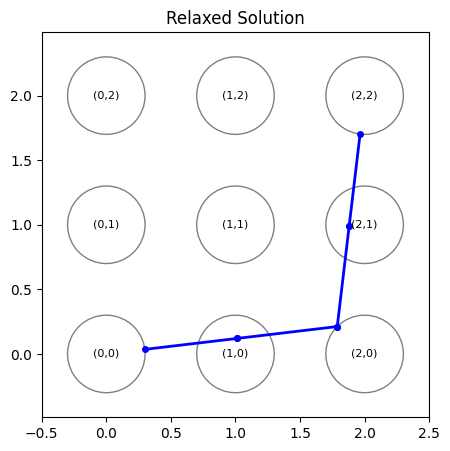

In [24]:
gcs = create_3x3_graph()
val = solve_gcs_relaxed(gcs)
print("Relaxed objective:", val)
plot_solution(gcs)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 12:40:49 AM: Your problem has 51 variables, 120 constraints, and 0 parameters.
(CVXPY) Apr 17 12:40:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 12:40:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 12:40:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 12:40:49 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 12:40:49 AM: Compiling problem (target solver=MOSEK).
(

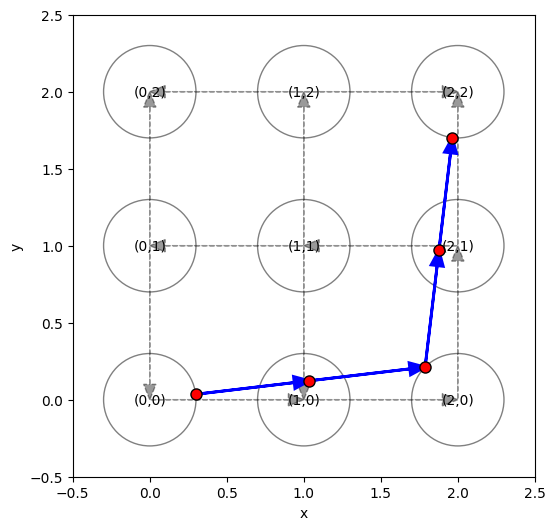

In [69]:

n = 3
radius = 0.3
Mv = 4.0  # big-M for vertex disks
Me = 1.0  # big-M for edge distances

# Vertex coordinates and indexing
tile_coords = [(i, j) for i in range(n) for j in range(n)]
V = len(tile_coords)
idx = {coord: k for k, coord in enumerate(tile_coords)}

# Directed edges (from -> to)
edge_list = [
    ((0,0),(1,0)), ((1,0),(2,0)), ((2,0),(2,1)),
    ((0,1),(0,0)), ((0,1),(0,2)),
    ((1,1),(1,0)), ((1,1),(0,1)), ((1,1),(1,2)),
    ((2,1),(1,1)), ((2,1),(2,2)),
    ((1,2),(0,2)), ((1,2),(2,2)),
]
E = len(edge_list)

#---------------------------------------------------------------------------
# Decision variables
#---------------------------------------------------------------------------
x = cp.Variable((V, 2), name="x")            # visit points
z_v = cp.Variable(V,   name="z_v")          # tile-use flags
z_e = cp.Variable(E,   name="z_e")          # edge-use flags
d  = cp.Variable(E, nonneg=True, name="d")  # edge distances

#---------------------------------------------------------------------------
# Build constraints
#---------------------------------------------------------------------------
constraints = []
# Vertex (tile) constraints
for k, (i, j) in enumerate(tile_coords):
    constraints += [z_v[k] >= 0, z_v[k] <= 1]
    constraints.append(
        cp.norm(x[k] - np.array([i, j])) \
        <= radius + Mv * (1 - z_v[k])
    )

# Edge constraints
cost_terms = []
for e_idx, ((i1, j1), (i2, j2)) in enumerate(edge_list):
    u = idx[(i1, j1)]
    v = idx[(i2, j2)]
    constraints += [z_e[e_idx] >= 0, z_e[e_idx] <= 1]
    # distance coupling
    constraints.append(
        d[e_idx] >= cp.norm(x[v] - x[u]) - Me * (1 - z_e[e_idx])
    )
    constraints.append(
        d[e_idx] <= Me * z_e[e_idx]
    )
    # logical coupling
    constraints += [
        z_e[e_idx] <= z_v[u],
        z_e[e_idx] <= z_v[v],
        z_e[e_idx] >= z_v[u] + z_v[v] - 1
    ]
    cost_terms.append(d[e_idx])

# Flow (path) conservation
start = (0, 0)
goal  = (n-1, n-1)
for k, coord in enumerate(tile_coords):
    # sum of incoming minus outgoing
    inflow  = sum(z_e[i] for i, e in enumerate(edge_list) if e[1] == coord)
    outflow = sum(z_e[i] for i, e in enumerate(edge_list) if e[0] == coord)
    if coord == start:
        constraints.append(outflow - inflow == 1)
    elif coord == goal:
        constraints.append(inflow - outflow == 1)
    else:
        constraints.append(inflow - outflow == 0)

# Objective: minimize total traveled distance
objective = cp.Minimize(cp.sum(cost_terms))

#---------------------------------------------------------------------------
# Solve
#---------------------------------------------------------------------------
problem = cp.Problem(objective, constraints)
result  = problem.solve(solver=cp.MOSEK, verbose=True)
print("Optimal objective value:", result)

#---------------------------------------------------------------------------
# Plot solution 
#---------------------------------------------------------------------------
plt.figure(figsize=(6,6))
ax = plt.gca()

# Draw disks and node labels
for i, j in tile_coords:
    circle = plt.Circle((i, j), radius, fill=False, color='gray', linewidth=1)
    ax.add_patch(circle)
    plt.text(i, j, f"({i},{j})", ha='center', va='center')

for (i1, j1), (i2, j2) in edge_list:
    dx, dy = i2 - i1, j2 - j1
    ax.arrow(i1, j1, dx, dy,
             length_includes_head=True,
             head_width=0.08,     
             head_length=0.1,   
             linestyle='--',
             color='black',
             linewidth=1,
             alpha=0.4)

# Overlay chosen path edges in solid blue arrows
for e_idx, ((i1, j1), (i2, j2)) in enumerate(edge_list):
    if z_e[e_idx].value > 0.5:
        u, v = idx[(i1, j1)], idx[(i2, j2)]
        p1 = x[u].value
        p2 = x[v].value
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        ax.arrow(p1[0], p1[1], dx, dy,
                 length_includes_head=True,
                 head_width=0.08,   
                 head_length=0.1,   
                 color='blue',
                 linewidth=2)

# Highlight chosen vertices in red
for k, (i, j) in enumerate(tile_coords):
    if z_v[k].value > 0.5:
        px, py = x[k].value
        ax.plot(px, py, 'ro', markersize=8, markeredgecolor='k')

ax.set_aspect('equal')
plt.xlim(-0.5, n-0.5)
plt.ylim(-0.5, n-0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


